# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<center><img src='assets/Flowers.png' width=500px></center>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

In [1]:
# import resources
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import json
from datetime import datetime

In [2]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [3]:
print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.3.1
	• tf.keras version: 2.4.0
	• Running on GPU


## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [4]:
(training_set, test_set, validation_set), dataset_info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True, split=['train', 'test', 'validation'])


### Label Mapping

In [5]:
with open('label_map.json', 'r') as f:
    class_names_dict = json.load(f)

class_names = []
for n in range(102):
    class_names.append(class_names_dict['{}'.format(n+1)])
print(class_names)

['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia', 'cau

## Explore Dataset

In [6]:
# get some information on dataset including number of examples, splits, feature shape, dataset makeup etc.
print(dataset_info)

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    version=2.1.1,
    description='The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
in the United Kingdom. Each class consists of between 40 and 258 images. The images have
large scale, pose and light variations. In addition, there are categories that have large
variations within the category and several very similar categories.

The dataset is divided into a training set, a validation set and a test set.
The training set and validation set each consist of 10 images per class (totalling 1020 images each).
The test set consists of the remaining 6149 images (minimum 20 per class).',
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=102),
    }),
    total_num_examples=8

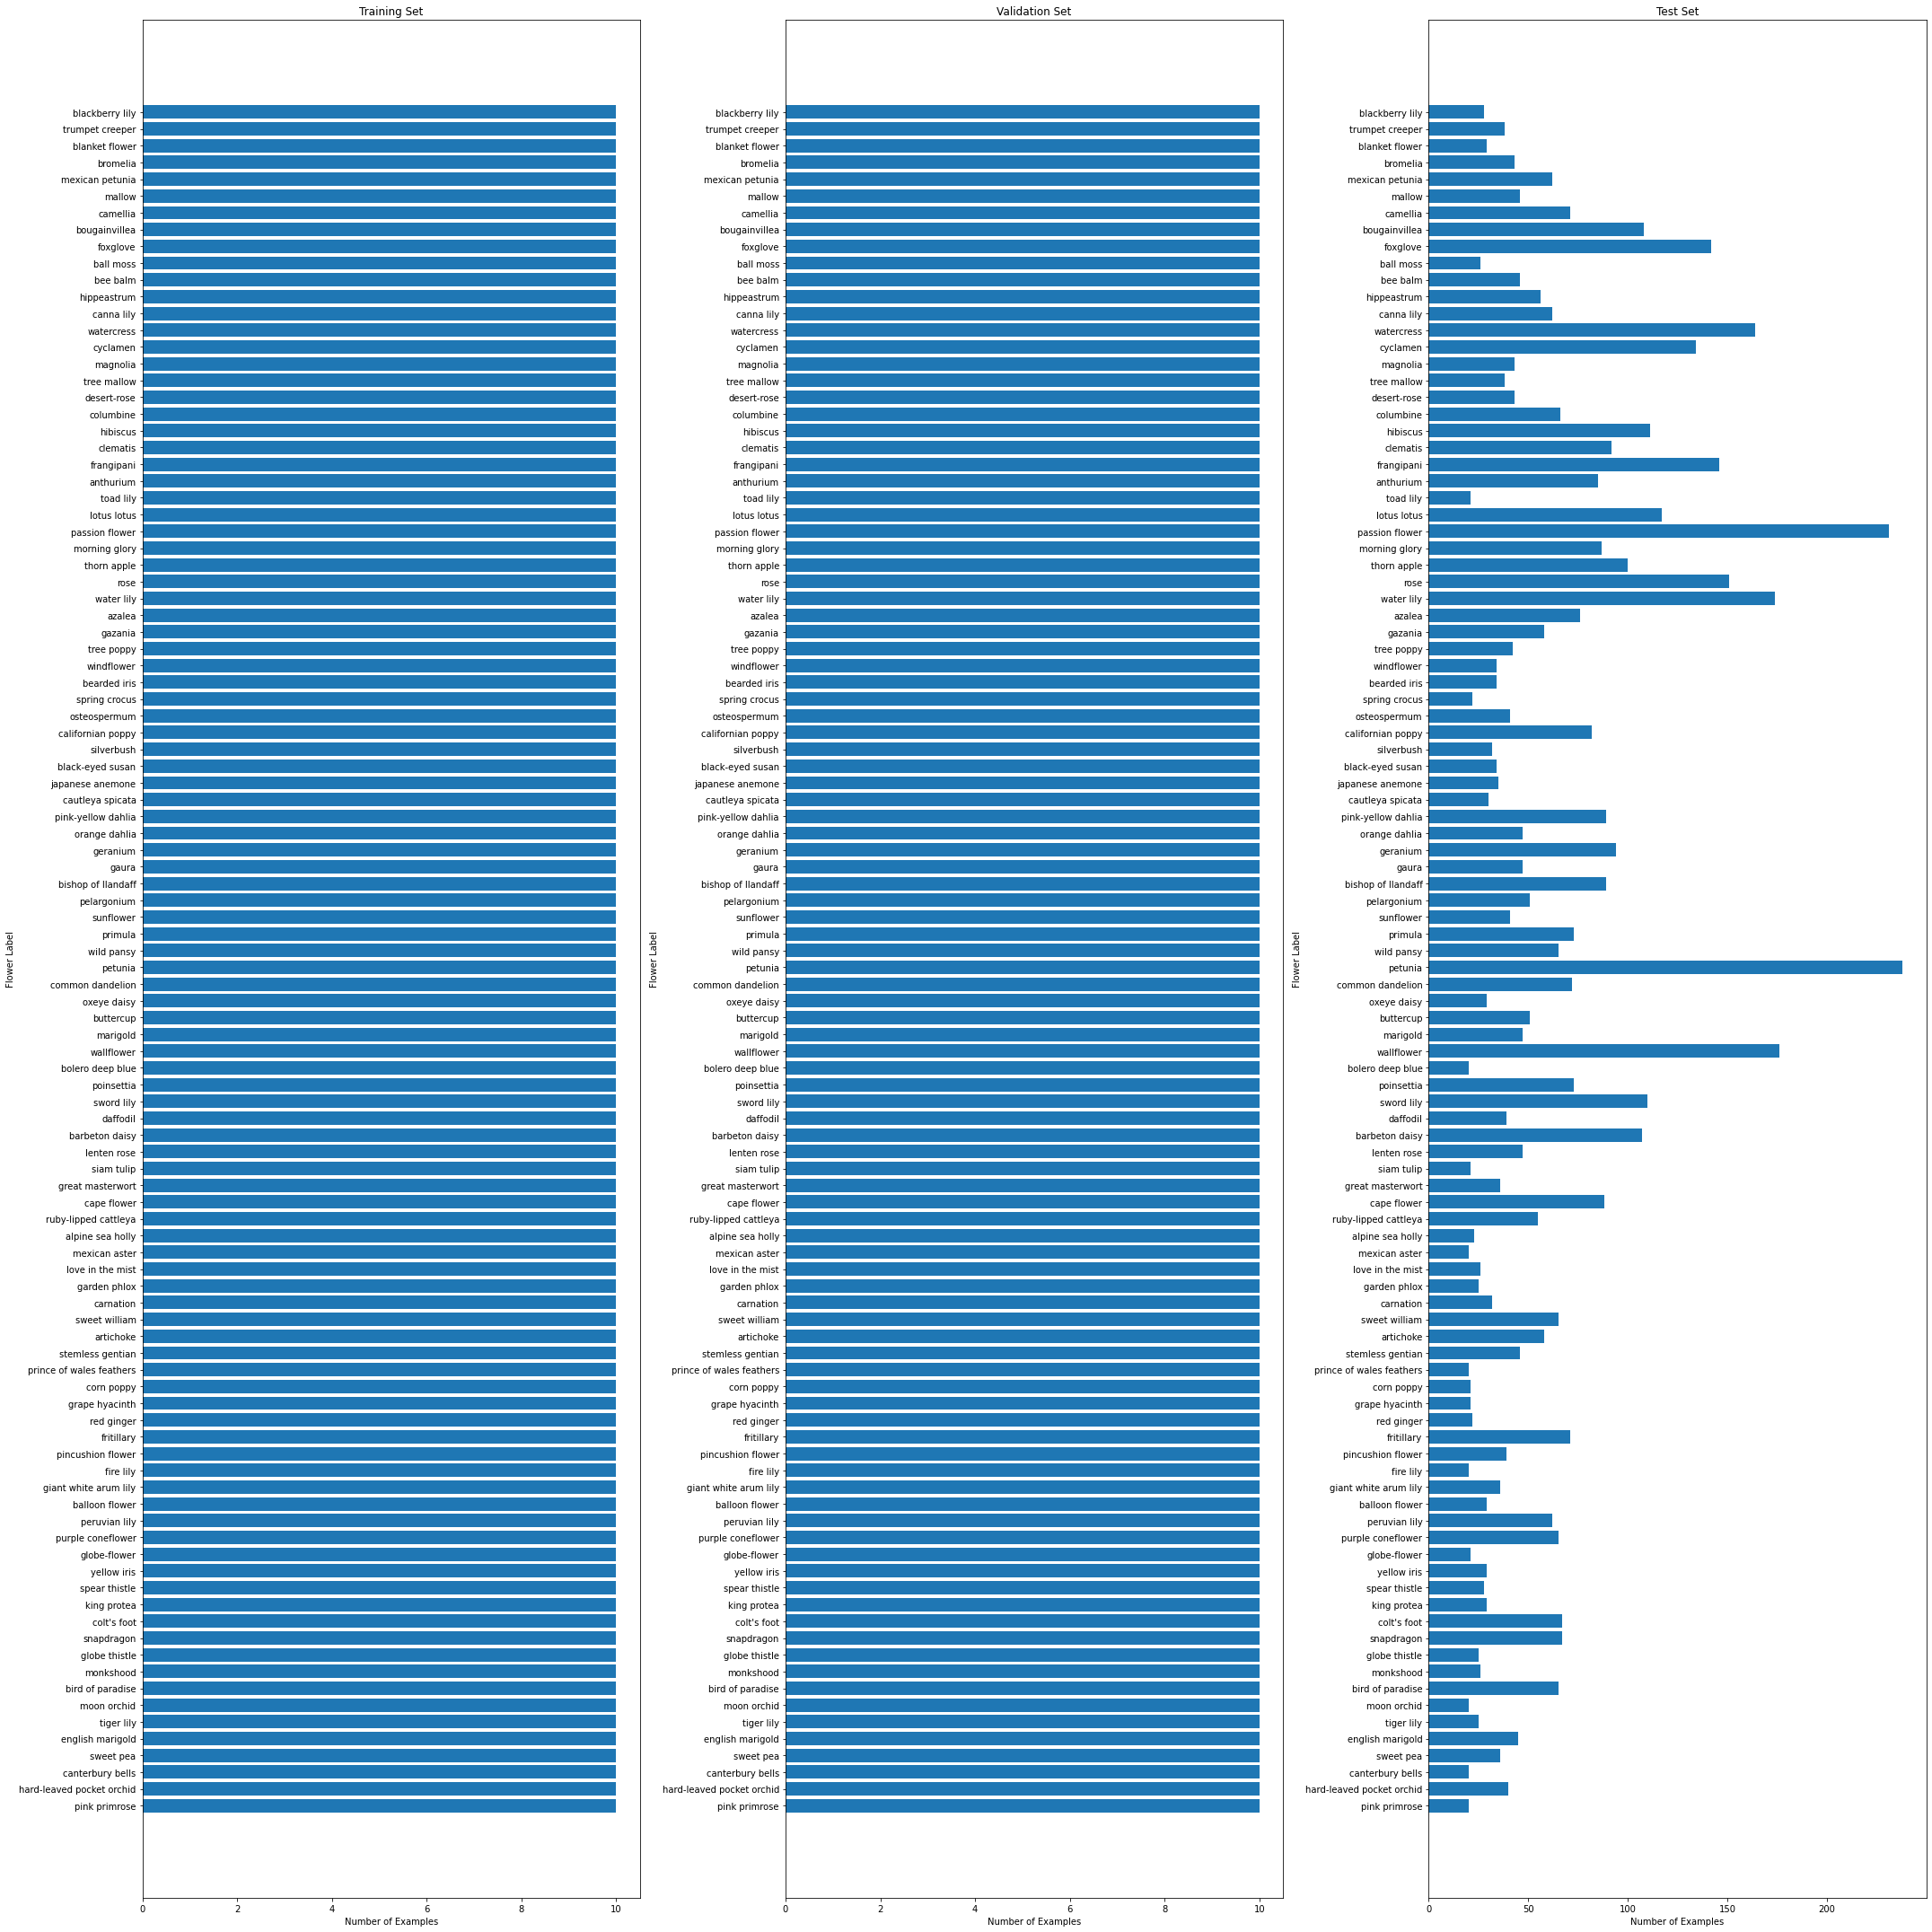

In [7]:
# check distribution of labels within various datasets
training_labels = []
validation_labels = []
test_labels = []
for image, label in training_set:
    training_labels.append(label.numpy())
for image, label in validation_set:
    validation_labels.append(label.numpy())
for image, label in test_set:
    test_labels.append(label.numpy())

y_pos = np.arange(102)
_, training_count = np.unique(np.array(training_labels), return_counts=True)
_, validation_count = np.unique(np.array(validation_labels), return_counts=True)
_, test_count = np.unique(np.array(test_labels), return_counts=True)

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(30,30), ncols=3)
ax1.barh(y_pos, training_count)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(class_names)
ax1.set_ylabel('Flower Label')
ax1.set_xlabel('Number of Examples')
ax1.set_title('Training Set')

ax2.barh(y_pos, validation_count)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(class_names)
ax2.set_ylabel('Flower Label')
ax2.set_xlabel('Number of Examples')
ax2.set_title('Validation Set')

ax3.barh(y_pos, test_count)
ax3.set_yticks(y_pos)
ax3.set_yticklabels(class_names)
ax3.set_ylabel('Flower Label')
ax3.set_xlabel('Number of Examples')
ax3.set_title('Test Set')

plt.tight_layout()
plt.show()

## Format Dataset

In [8]:
image_size = 224

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size, image_size),
    layers.experimental.preprocessing.Rescaling(1./255)
], name='resize_and_rescale')


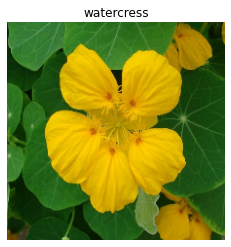

Min and max pixel values:  0.0 1.0


In [9]:
# look at an example image
image, label = list(validation_set.as_numpy_iterator())[0]

image = resize_and_rescale(image)

plt.subplot()
plt.imshow(image, cmap=plt.cm.binary)
plt.title(class_names[label])
plt.axis('off')
plt.show()

print('Min and max pixel values: ', image.numpy().min(), image.numpy().max())


## Data Augmentation

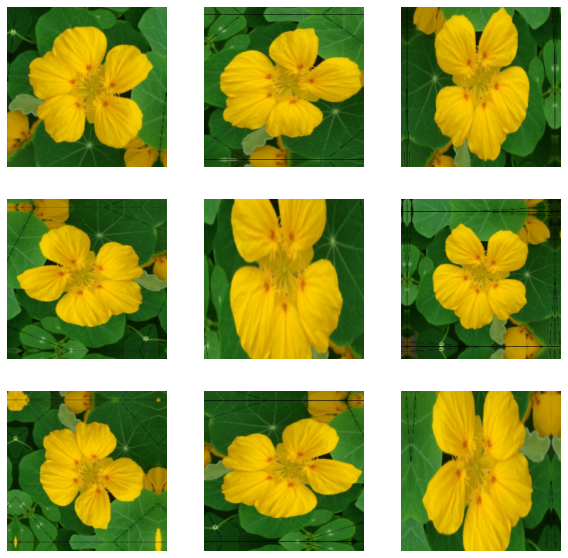

In [10]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal'),
    layers.experimental.preprocessing.RandomRotation(0.4),
    layers.experimental.preprocessing.RandomZoom(0.5, 0.2)
], name='data_augmentation')

image = tf.expand_dims(image, 0)

# have a look at a few examples
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3,3,i+1)
    plt.imshow(augmented_image[0])
    plt.axis('off')

## Create Pipeline


In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, shuffle=False, augment=False, batch_size = 32):
    # resize and rescale all dataset
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)
    
    ds = ds.batch(batch_size)
    
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    
    return ds.prefetch(buffer_size=AUTOTUNE)


In [12]:
training_batch = prepare(training_set, shuffle=True, augment=True)
validation_batch = prepare(validation_set)
test_batch = prepare(test_set)

## Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

### Training Model - Attempt #1

Initially started off with:

1. Flatten layer
2. Dropout layer to manage overfitting
3. Output Dense layer

In [13]:
def build_model(output_size=102, hidden_layers=[], dropout_rate=0.3):
    mobilenet_url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'

    # the size of training dataset is small and ImageNet consists of similar data to the training dataset, hence a new fully connected layer will be added to the end of mobilenet cnn
    mobilenet_layer = hub.KerasLayer(mobilenet_url, input_shape=(image_size, image_size, 3), trainable=False)

    model = tf.keras.Sequential([
        mobilenet_layer,
        layers.Flatten(),
        layers.Dropout(dropout_rate),
    ], name='training_model')

    n = 0
    for i in hidden_layers:
        n += 1
        model.add(layers.Dense(i, activation='relu', name='h_{}'.format(n)))
        model.add(layers.Dropout(dropout_rate))

    model.add(tf.keras.layers.Dense(output_size, activation='softmax', name='output'))

    optimizer = tf.keras.optimizers.Adam()

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model_1 = build_model()
model_1.summary()

Model: "training_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
output (Dense)               (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [14]:
# train the model
epochs = 30

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)
    ]

history_1 = model_1.fit(training_batch, epochs=epochs, validation_data=validation_batch, callbacks=callbacks)

Epoch 1/30
32/32 [==============================] - 6s 199ms/step - loss: 4.6878 - accuracy: 0.0500 - val_loss: 3.5535 - val_accuracy: 0.2255
Epoch 2/30
32/32 [==============================] - 6s 194ms/step - loss: 3.1296 - accuracy: 0.2706 - val_loss: 2.6394 - val_accuracy: 0.4480
Epoch 3/30
32/32 [==============================] - 6s 199ms/step - loss: 2.2656 - accuracy: 0.4755 - val_loss: 2.1195 - val_accuracy: 0.5569
Epoch 4/30
32/32 [==============================] - 6s 197ms/step - loss: 1.7430 - accuracy: 0.6108 - val_loss: 1.7929 - val_accuracy: 0.6412
Epoch 5/30
32/32 [==============================] - 6s 185ms/step - loss: 1.4321 - accuracy: 0.6745 - val_loss: 1.6203 - val_accuracy: 0.6382
Epoch 6/30
32/32 [==============================] - 7s 214ms/step - loss: 1.2395 - accuracy: 0.7373 - val_loss: 1.4477 - val_accuracy: 0.6804
Epoch 7/30
32/32 [==============================] - 6s 202ms/step - loss: 1.0717 - accuracy: 0.7520 - val_loss: 1.3651 - val_accuracy: 0.6931
Epoch 

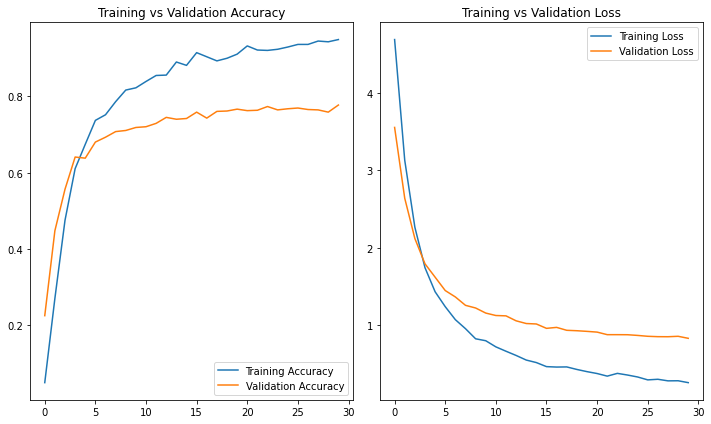

In [15]:
def plotHistory(historyObj, epochs):
    training_accuracy = historyObj['accuracy']
    validation_accuracy = historyObj['val_accuracy']

    training_loss = historyObj['loss']
    validation_loss = historyObj['val_loss']

    epoch_range = range(len(training_accuracy))

    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    plt.plot(epoch_range, training_accuracy, label='Training Accuracy')
    plt.plot(epoch_range, validation_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training vs Validation Accuracy')

    plt.subplot(1,2,2)
    plt.plot(epoch_range, training_loss, label='Training Loss')
    plt.plot(epoch_range, validation_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training vs Validation Loss')

    plt.tight_layout()
    plt.show()

plotHistory(history_1.history, epochs)


In [16]:
loss, accuracy = model_1.evaluate(test_batch)

print('\nThe model has:')
print('\u2022Loss: {:,.3f}'.format(loss))
print('\u2022Accuracy: {:,.3%}'.format(accuracy))

193/193 [==============================] - 16s 82ms/step - loss: 0.9820 - accuracy: 0.7491

The model has:
•Loss: 0.982
•Accuracy: 74.906%


### Training Model - Attempt #2

Based on Attempt #1, the model seems to be showing signs of over-fitting despite incorporating regularization techniques such as dropouts and data augmentation.

The model has no problem fitting the training model which means the MobileNet layer is doing too good a job?
What are some other ways to help the model generalize better?

Is it because the training dataset is too small? What if we train on the test set which is a bigger dataset and test on the training set instead?


In [17]:
model_2 = build_model()

epochs = 10
history_2 = model_2.fit(test_batch, epochs=epochs, validation_data=validation_batch, callbacks=callbacks)

Epoch 1/10
193/193 [==============================] - 16s 85ms/step - loss: 2.2449 - accuracy: 0.5115 - val_loss: 1.1186 - val_accuracy: 0.7667
Epoch 2/10
193/193 [==============================] - 16s 82ms/step - loss: 0.7088 - accuracy: 0.8476 - val_loss: 0.7078 - val_accuracy: 0.8500
Epoch 3/10
193/193 [==============================] - 16s 83ms/step - loss: 0.4482 - accuracy: 0.9062 - val_loss: 0.5745 - val_accuracy: 0.8725
Epoch 4/10
193/193 [==============================] - 17s 90ms/step - loss: 0.3244 - accuracy: 0.9312 - val_loss: 0.5064 - val_accuracy: 0.8863
Epoch 5/10
193/193 [==============================] - 17s 87ms/step - loss: 0.2462 - accuracy: 0.9502 - val_loss: 0.4602 - val_accuracy: 0.8892
Epoch 6/10
193/193 [==============================] - 18s 95ms/step - loss: 0.1921 - accuracy: 0.9639 - val_loss: 0.4339 - val_accuracy: 0.9010
Epoch 7/10
193/193 [==============================] - 19s 100ms/step - loss: 0.1586 - accuracy: 0.9722 - val_loss: 0.4056 - val_accuracy

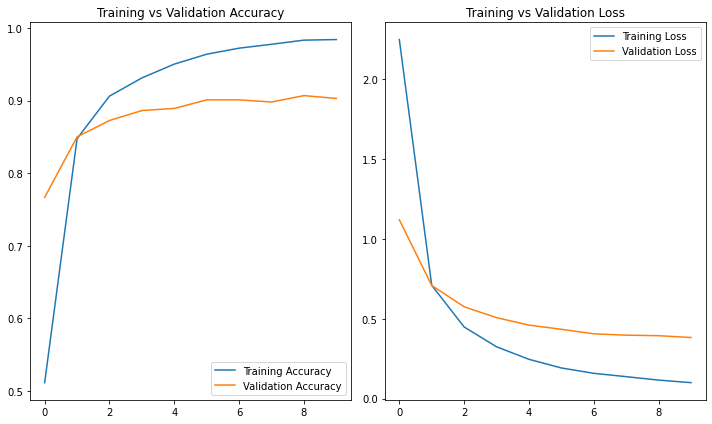

In [18]:
plotHistory(history_2.history, epochs)

In [19]:
loss, accuracy = model_2.evaluate(training_batch)

print('\nThe model has:')
print('\u2022Loss: {:,.3f}'.format(loss))
print('\u2022Accuracy: {:,.3%}'.format(accuracy))

32/32 [==============================] - 5s 149ms/step - loss: 1.1087 - accuracy: 0.7039

The model has:
•Loss: 1.109
•Accuracy: 70.392%


By training on the test set (bigger dataset), the validation accuracy was higher for training, but the test accuracy (on the training dataset) was low. This again suggests overfitting which was the initial problem we have.

## Save the Model

We will save model_1 as it is a better model. model_2 was more of an experiment.

In [20]:
model_name = model_1.name

now = datetime.now()
now_str = '{}{}{}_{}{}{}'.format(now.year,now.month,now.day,now.hour,now.minute,now.second)
filepath = './models/{}_{}.h5'.format(model_name, now_str)
model_1.save(filepath, overwrite=False)


## Load the Keras Model

In [21]:
loaded_model = tf.keras.models.load_model(filepath, custom_objects={'KerasLayer': hub.KerasLayer})

loaded_model.summary()

Model: "training_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
output (Dense)               (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


## Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [22]:
# process image function
def process_image(img_arr, img_size=224):
    image = tf.cast(img_arr, tf.float32)
    image = tf.image.resize(image, (img_size, img_size))
    image /= 255.

    return image

To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

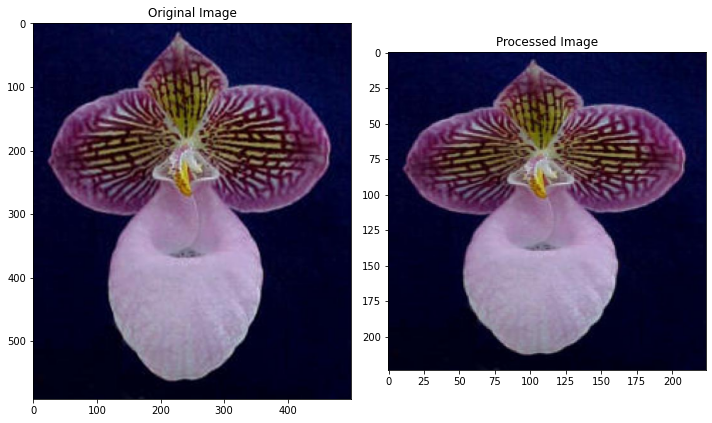

In [23]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [24]:
# predict function
def predict(image_path, model, top_k):
    img = Image.open(image_path)
    img = np.asarray(img)
    img = process_image(img)
    img = np.expand_dims(img, 0)
    pred = model.predict(img)

    top_k_classes = np.argpartition(pred[0], -top_k)[-top_k:]
    top_k_preds = np.partition(pred[0], -top_k)[-top_k:]

    top_k_classnames = [class_names[x] for x in top_k_classes]

    return top_k_preds, top_k_classnames, np.squeeze(img, axis=0)

# plot image and class probability distribution
def plot_prob_distribution(probs, classes, image, img_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(image, cmap=plt.cm.binary)
    ax1.axis('off')
    ax1.set_title(img_name)

    ax2.barh(classes, probs)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

## Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

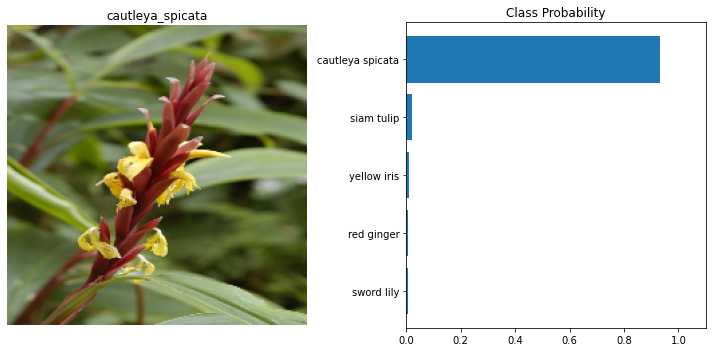

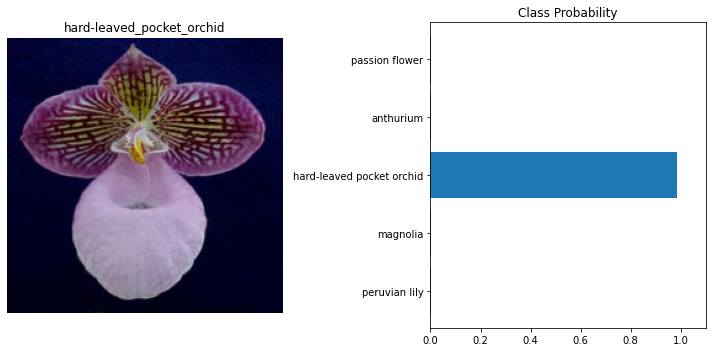

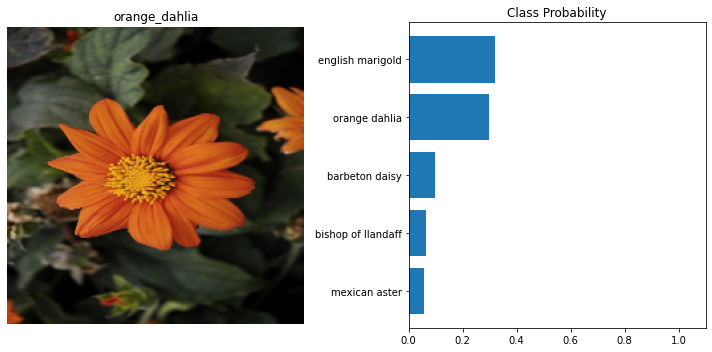

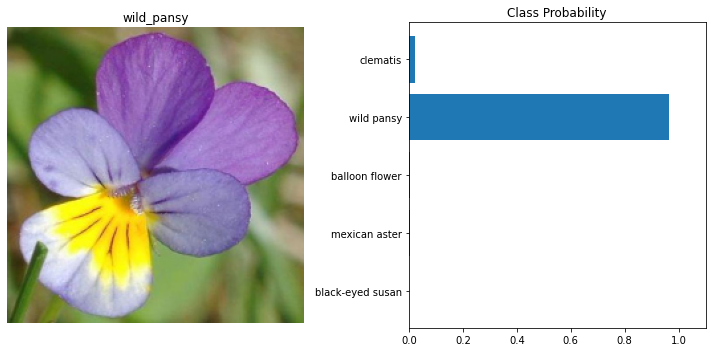

In [26]:
test_images = ['cautleya_spicata', 'hard-leaved_pocket_orchid', 'orange_dahlia', 'wild_pansy']

for img_name in test_images:
    probs, classes, image = predict('./test_images/{}.jpg'.format(img_name), loaded_model, 5)
    plot_prob_distribution(probs, classes, image, img_name)